- Now using the sklearn Pipeline 
- Fixed the implementation of OneHot Encoding, it doesn't increase MSEs anymore (it was a coding mistake of course) but decreases them slightly
- Summarized two rain categories into one
- Implemented (linear) time feature engineering and time-based cross-validation

- Missing:
    - Remove year as feature
    - Regularization
    - Grid-Search for the trees
    - Random Forest
    - Quantile Regression

In [115]:
import pandas as pd

In [116]:
df = pd.read_csv('data/raw/weather-hour.csv')

In [117]:
weather = df.iloc[:,1:].copy()

In [118]:
weather.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [119]:
weather["cnt"].describe()
# min = 1
# max = 977

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

### Preprocessing:

In [120]:
# find missing values
weather.isnull().sum()

dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [121]:
weather.shape

(17379, 16)

In [122]:
X = weather.drop(columns=["casual", "registered", "cnt"]) # removing target variables
y = weather["cnt"]

In [123]:
# feature engineering: removing date column
X = X.drop(columns=["dteday"])

In [124]:
X["weathersit"].value_counts()
# 1 clear
# 2 misty
# 3 rain
# 4 heavy rain

weathersit
1    11413
2     4544
3     1419
4        3
Name: count, dtype: int64

In [125]:
X["weathersit"] = (
    X["weathersit"]
    .replace(to_replace=4, value=3)
)

In [126]:
X["weathersit"].value_counts()

weathersit
1    11413
2     4544
3     1422
Name: count, dtype: int64

In [127]:
X["season"].value_counts() # looks good

season
3    4496
2    4409
1    4242
4    4232
Name: count, dtype: int64

### Defining evaluation functions:

In [128]:
from sklearn.model_selection import train_test_split

seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 
#To make the validation set 20% of the original data we use test size 0.25 as 0.25*0.8=0.2

In [129]:
from sklearn.metrics import mean_squared_error

def fit_predict_eval(pipe, X_train, y_train, X_test, y_test):
    # fit the model
    pipe.fit(X_train, y_train)

    # make predictions on the validation set
    y_train_pred = pipe.predict(X_train)

    # make predictions on the test set
    y_pred = pipe.predict(X_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_pred)  

    return mse_train, mse_test, y_train_pred, y_pred

In [130]:
from sklearn.model_selection import cross_val_score, cross_validate
import numpy as np

def fit_eval_cv(pipe, X, y):
    # fit the model
    pipe.fit(X_train, y_train)

    scores = cross_validate(pipe, X, y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

    mse_train = -np.mean(scores['train_score'])
    mse_test   = -np.mean(scores['test_score'])
    
    return mse_train, mse_test

In [131]:
from sklearn.model_selection import TimeSeriesSplit

# 1000 test datapoints represent a bit less than a month and a half of contiguous test data

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48, # 2 day = 48h gap between train & test
    max_train_size=10000,
    test_size=1000,
)

In [132]:
def fit_eval_ts_cv(pipe, X, y, ts_cv):
    
    pipe.fit(X_train, y_train)

    scores = cross_validate(pipe, X, y, cv=ts_cv, scoring='neg_mean_squared_error', return_train_score=True)
    
    mse_train = -np.mean(scores['train_score'])
    mse_test   = -np.mean(scores['test_score'])
    
    return mse_train, mse_test

### Models:

#### Grid Search
We can Grid Search if we should One Hot encode the colums :D

In [133]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
categorical_columns = ['season', 'yr', 'weathersit']

onehot_transformer =  ColumnTransformer(
        transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)],
        remainder='passthrough')

In [134]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

pipe_tree_gridsearch = Pipeline(
      [
      ('transformer', 'passthrough'),
      ('model', DecisionTreeRegressor(random_state=42))
      ]
      )

In [164]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__max_depth': [3, 5, 7, 10, 15],
    'model__min_samples_split': [2, 5, 10, 15, 20],
    'transformer': ['passthrough', onehot_transformer]
}

search = GridSearchCV(pipe_tree_gridsearch, n_jobs=1, param_grid=param_grid)
search.fit(X, y)

print(search.best_params_)

pipe_tree_gridsearch = search.best_estimator_ 

fit_eval_ts_cv(pipe_tree_gridsearch, X, y, ts_cv)

{'model__max_depth': 10, 'model__min_samples_split': 15, 'transformer': ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['season', 'yr', 'weathersit'])])}


(np.float64(2478.7523410564927), np.float64(8925.061275801985))

In [136]:
from sklearn.linear_model import LinearRegression

pipe_LR_gridsearch = Pipeline(
      [
      ('transformer', 'passthrough'),
      ('model', LinearRegression())
      ]
      )

In [137]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'transformer': ['passthrough', onehot_transformer]
}

search = GridSearchCV(pipe_LR_gridsearch, n_jobs=1, param_grid=param_grid)
search.fit(X, y)

print(search.best_params_)

pipe_LR_gridsearch = search.best_estimator_ 

fit_eval_ts_cv(pipe_LR_gridsearch, X, y, ts_cv)

{'transformer': ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['season', 'yr', 'weathersit'])])}


(np.float64(20548.92608967728), np.float64(32612.98245511076))

#### Simple Models (kept for plotting):

In [138]:
pipe_LR = Pipeline(steps=[
      ('model', LinearRegression())]
      )

In [139]:
y_pred = fit_predict_eval(pipe_LR, X_train, y_train, X_test, y_test)[3]

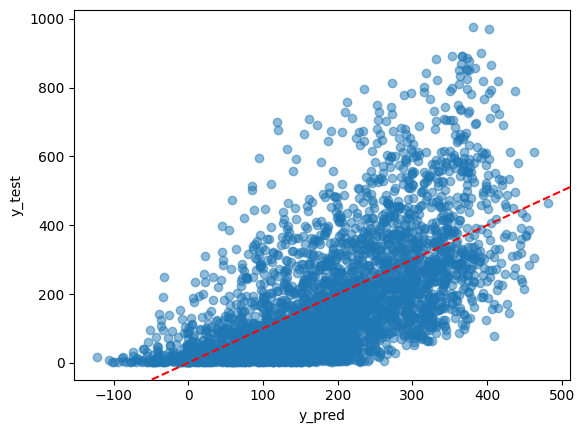

In [140]:
import matplotlib.pyplot as plt

plt.scatter(y_pred, y_test, alpha=0.5)
plt.xlabel('y_pred')
plt.ylabel('y_test')
# add the line y=x for reference
plt.axline((0, 0), slope = 1, color='red', linestyle='--') 
plt.show()

In [141]:
from sklearn.tree import plot_tree

pipe_tree_3 = Pipeline(steps=[
      ('model', DecisionTreeRegressor(max_depth = 3, random_state=42))]
      )

In [142]:
tree_model = pipe_tree_3.fit(X_train, y_train)

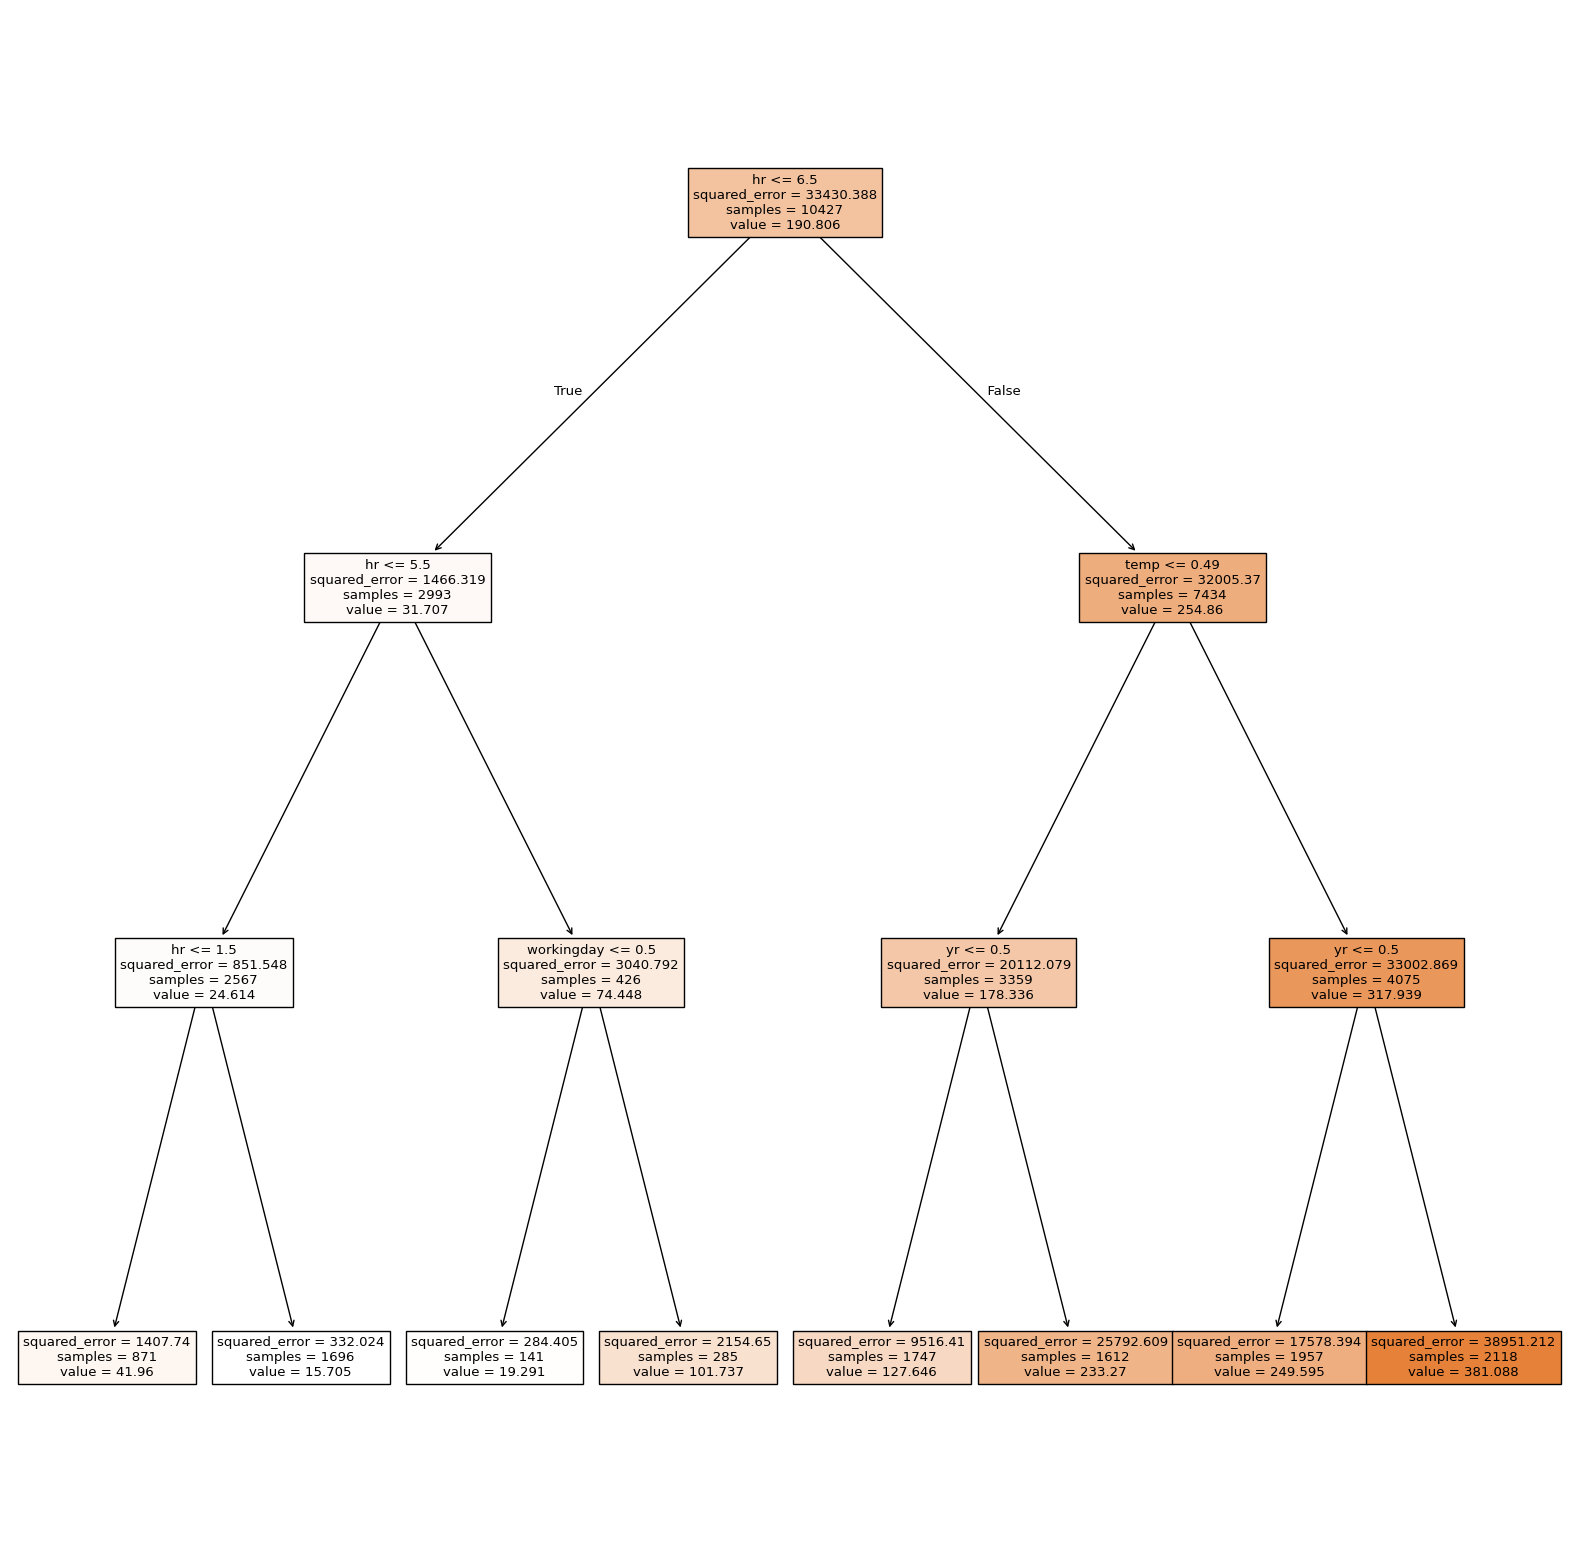

In [143]:
#Display the regression tree
plt.figure(figsize=(20,20))
plot_tree(pipe_tree_3.named_steps['model'], feature_names = X_train.columns, filled=True)
plt.show()

## Time Features

In [150]:
# from https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#time-based-cross-validation

In [151]:
weather.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


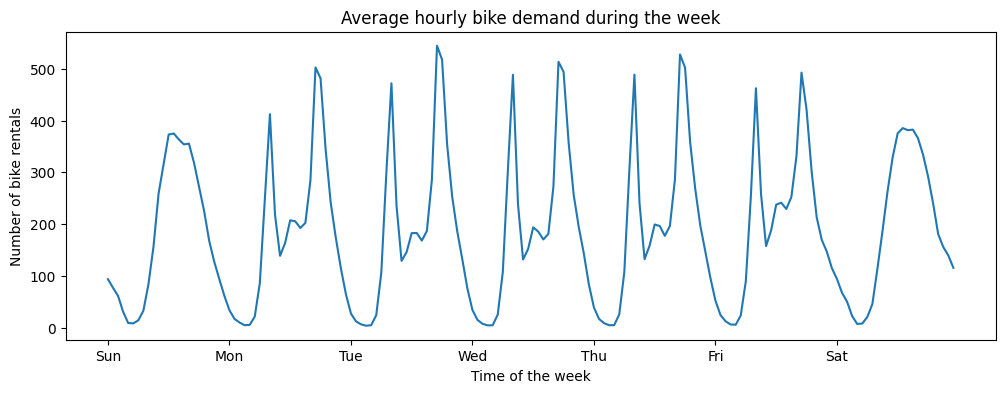

In [152]:
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df.groupby(["weekday", "hr"])["cnt"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

In [153]:
# they rescale the target to predict relative demand
# I don't do that here but we could
# y = df["count"] / df["count"].max()

### Encoding time as categories (Onehot)

! here I just assume that one hot encoding the features makes sense, since it did in the girdsearches above

In [ ]:
onehot_time = ColumnTransformer(
        transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns),
                      ('time', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ["hr", "weekday", "mnth"])],
        remainder='passthrough')

In [ ]:
pipe_LR_proc_onehot = Pipeline(steps=[
    ('transformer', onehot_time),
    ('model', LinearRegression())
])

### Encoding time with sin / cos 

In [156]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

**Intuition:**

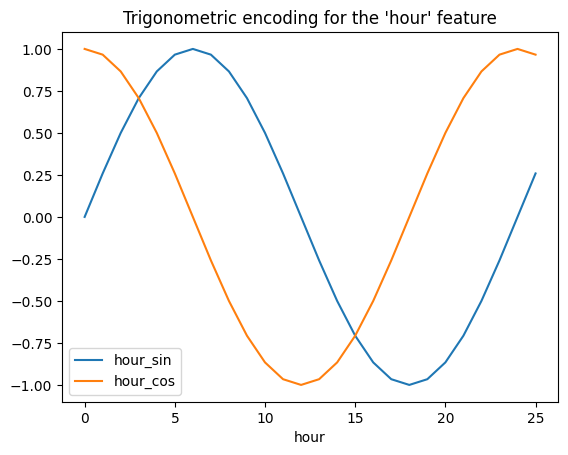

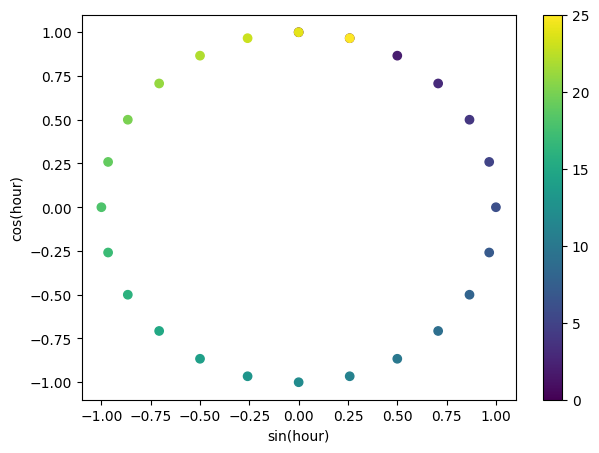

In [157]:
hour_df = pd.DataFrame(
    np.arange(26).reshape(-1, 1),
    columns=["hour"],
)
hour_df["hour_sin"] = sin_transformer(24).fit_transform(hour_df)["hour"]
hour_df["hour_cos"] = cos_transformer(24).fit_transform(hour_df)["hour"]
hour_df.plot(x="hour")
_ = plt.title("Trigonometric encoding for the 'hour' feature")

fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(hour_df["hour_sin"], hour_df["hour_cos"], c=hour_df["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

In [ ]:
onehot_cos_sin = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns),
            ("month_sin", sin_transformer(12), ["mnth"]),
            ("month_cos", cos_transformer(12), ["mnth"]),
            ("weekday_sin", sin_transformer(7), ["weekday"]),
            ("weekday_cos", cos_transformer(7), ["weekday"]),
            ("hour_sin", sin_transformer(24), ["hr"]),
            ("hour_cos", cos_transformer(24), ["hr"]),
        ],
        remainder='passthrough'
    )

In [ ]:
pipe_LR_proc_cos_sin = Pipeline(steps=[
    ('transformer', onehot_cos_sin),
    ('model', LinearRegression())
])

You can also use splines: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#periodic-spline-features

### Grid Search the time feature method:

In [167]:
pipe_LR_gridsearch_time = Pipeline(
      [
      ('transformer', 'passthrough'),
      ('model', LinearRegression())
      ]
      )

In [169]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'transformer': [onehot_transformer, onehot_time, onehot_cos_sin], # only onehot-features, also onehot-time, or also cossin-time
}

search = GridSearchCV(pipe_LR_gridsearch_time, n_jobs=1, param_grid=param_grid)
search.fit(X, y)

print(search.best_params_)

pipe_LR_gridsearch_time = search.best_estimator_ 

fit_eval_ts_cv(pipe_LR_gridsearch_time, X, y, ts_cv)

{'transformer': ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['season', 'yr', 'weathersit']),
                                ('time',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['hr', 'weekday', 'mnth'])])}


(np.float64(9798.429380750178), np.float64(16393.430499191913))

In [173]:
pipe_tree_gridsearch_time = Pipeline(
      [
      ('transformer', 'passthrough'),
      ('model', DecisionTreeRegressor(random_state=42))
      ]
      )

In [175]:
param_grid = {
    'model__max_depth': [3, 5, 7, 10, 15, 20],
    'model__min_samples_split': [2, 5, 10, 15, 20],
    'transformer': [onehot_transformer, onehot_time, onehot_cos_sin], # only onehot-features, also onehot-time, or also cossin-time
}

search = GridSearchCV(pipe_tree_gridsearch_time, n_jobs=1, param_grid=param_grid)
search.fit(X, y)

print(search.best_params_)

pipe_tree_gridsearch_time = search.best_estimator_ 

fit_eval_ts_cv(pipe_tree_gridsearch_time, X, y, ts_cv)

{'model__max_depth': 15, 'model__min_samples_split': 15, 'transformer': ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['season', 'yr', 'weathersit']),
                                ('month_sin',
                                 FunctionTransformer(func=<function sin_transformer.<locals>.<lambda> at 0x000001D3442459E0>),
                                 ['mnth']),
                                ('month_cos',
                                 FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x0...
                                 ['weekday']),
                                ('weekday_cos',
                                 FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x000001D344245760>),
                                 ['weekda

(np.float64(1105.4709834024072), np.float64(9511.143542624952))

## Results (time-based cv):

In [ ]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

In [190]:
# comparing the models

# LR no time feature engineering
pipe_LR_gridsearch.fit(X.iloc[train_0], y.iloc[train_0])
naive_linear_predictions = pipe_LR_gridsearch.predict(X.iloc[test_0])

# tree no time feature engineering
pipe_tree_gridsearch.fit(X.iloc[train_0], y.iloc[train_0])
naive_tree_predictions = pipe_tree_gridsearch.predict(X.iloc[test_0])

# LR onehot time features
pipe_LR_proc_onehot.fit(X.iloc[train_0], y.iloc[train_0])
one_hot_linear_predictions = pipe_LR_proc_onehot.predict(X.iloc[test_0])

# LR cossin time features
pipe_LR_proc_cos_sin.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_cossin_linear_predictions = pipe_LR_proc_cos_sin.predict(X.iloc[test_0])

# grid searched tree (cossin time features)
pipe_tree_gridsearch_time.fit(X.iloc[train_0], y.iloc[train_0])
best_tree_predictions = pipe_tree_gridsearch_time.predict(X.iloc[test_0])

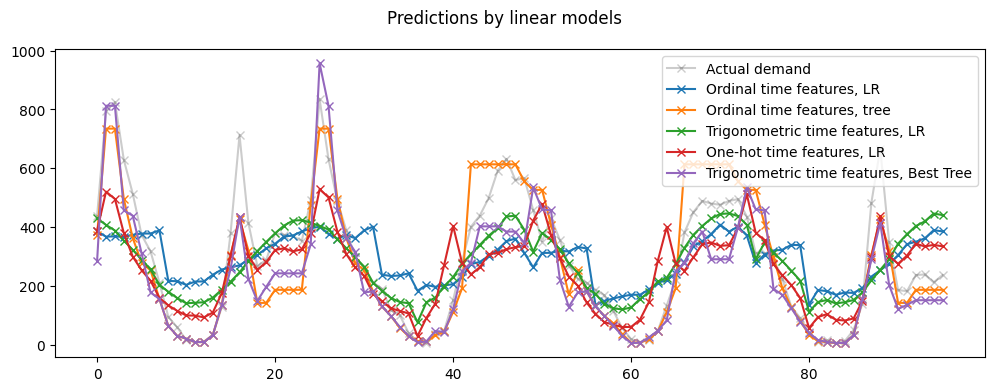

In [196]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by linear models")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)

ax.plot(
    naive_linear_predictions[last_hours], 
        "x-", 
        label="Ordinal time features, LR"
)

ax.plot(
    naive_tree_predictions[last_hours], 
        "x-", 
        label="Ordinal time features, tree"
)

ax.plot(
    cyclic_cossin_linear_predictions[last_hours],
    "x-",
    label="Trigonometric time features, LR",
)

ax.plot(
    one_hot_linear_predictions[last_hours],
    "x-",
    label="One-hot time features, LR",
)

ax.plot(
    best_tree_predictions[last_hours],
    "x-",
    label="Trigonometric time features, Best Tree",
)
_ = ax.legend()

In [185]:
model_scores = dict()
models = [
    pipe_tree_gridsearch, 
    pipe_LR_gridsearch, 
    # pipe_LR,                  for visualization
    # pipe_tree_3,              for visualization
    pipe_LR_proc_onehot, 
    pipe_LR_proc_cos_sin,
    # pipe_LR_gridsearch_time,  same as pipe_LR_proc_onehot
    pipe_tree_gridsearch_time]

for model in models:
    model_scores[model] = fit_eval_ts_cv(model, X, y, ts_cv)

In [186]:
for pipe, scores in model_scores.items():
    model_name = str(pipe.named_steps['model'])
    print(pipe)
    print(f"train mse: {scores[0]:.2f}, test mse: {scores[1]:.2f}")

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['season', 'yr',
                                                   'weathersit'])])),
                ('model',
                 DecisionTreeRegressor(max_depth=10, min_samples_split=15,
                                       random_state=42))])
train mse: 2478.75, test mse: 8925.06
Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                 

I would argue that our "best tree" is overfitting still, but would have to check